In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype
from datetime import datetime

In [118]:
!pip install tensorflow

In [119]:
import tensorflow as tf

In [120]:
pd.options.mode.chained_assignment = None 

In [121]:
!pip install keras

In [122]:
!pip install scikeras

In [123]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Embedding, LSTM, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [124]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [125]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
!pip install shap
import shap

In [ ]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [ ]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [ ]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [ ]:
project_id = PROJECT_ID # Fill project id
bqclient = bigquery.Client(location=LOCATION, project=project_id)

# Users data

-----

## Loading data

In [ ]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"

users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
users_table_id = project_id + "." + BQ_TABLE_USERS

In [ ]:
# job_config = bigquery.QueryJobConfig(
#     allow_large_results=True, destination=users_table_id, use_legacy_sql=True
# )

In [135]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [136]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [137]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  5000
Number of bots:  5000


In [138]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

In [139]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [140]:
# users_df = filter_df_for_balanced_classes(users_df2)
users_df = pd.DataFrame(users_df2).copy()

## Data preparation

In [141]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [142]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [143]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [144]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [145]:
column_to_remove

['withheld']

In [146]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [147]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})

In [148]:
users_df

,id,label,username,name,created_at,verified,protected,has_location,location,has_profile_image_url,has_pinned_tweet,url,followers_count,following_count,tweet_count,listed_count,has_description,description,descr_no_hashtags,descr_no_cashtags,descr_no_mentions,descr_no_urls,url_no_urls
0,1428769922507751429,1,BotoxAesthetics,dermalfillers Aesthetics botox,1629480285,0,0,1,"London , United Kingdom",1,0,https://t.co/CBDBvXnRKv,2,41,1,0,1,"Enhance fillers is a progressive company found in the city of Webminster,We offer a wide range of aesthetic services including Botox, Dysport, Xeomin,the Juvede",0,0,0,0,1
1,1484544053572419585,0,blessing_xettry,#Blessing xettry,1642777877,0,0,1,Nepal,1,0,,0,24,1,0,1,"Okay, well, maybe not forever. But at least until you make some changes.",0,0,0,0,0
2,842202106324951040,1,Mark11474609,Mark,1489631604,0,0,1,"Kelvin Grove, Brisbane",1,0,,3,22,4,0,0,,0,0,0,0,0
3,1447956502443069446,0,menametaken,winwinnie,1634054741,0,0,1,your walls,1,0,,0,20,1,0,1,20 | uni student | life goes brrr \nyes I do and it's called art\n#thickthighssavelifes,1,0,0,0,0
4,21309002,1,Sjouzan,Zuzana,1235058272,0,0,1,"Brighton, UK",1,0,,3,42,2,0,0,,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3275187061,0,LZconcussion,Concussion Recovery,1436585642,0,0,1,"Park City, UT",1,1,https://t.co/KpjP54TOGR,352,190,1094,18,1,"Specializing in #concussionmanagement including #education, #therapy options / recommendations & our standardized #ReturntoLifeandSport #exerciseprogression",5,0,0,0,1
9996,1485289449487572996,1,davie73smith,Davie,1642955586,0,0,0,None,1,0,,0,34,0,0,1,F U N,0,0,0,0,0
9997,1215382704876871680,0,USC_TrueVote,USC Election Cybersecurity Initiative,1578604840,0,0,1,washington dc,1,0,https://t.co/jlreKFwVEc,608,1265,1095,11,1,"Platform, party, and vendor-agnostic.\nOur candidate is democracy. ����\nTraining in all 50 states ✈ �� ��\nSupport from @google\nUpcoming Training Events ��",0,0,1,0,1
9998,1480725883820208131,1,Theresa823,Theresa Coleman,1641867569,0,0,0,None,1,0,,0,5,0,0,0,,0,0,0,0,0


#### Null and NaN statistics

In [149]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 3476
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [150]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [151]:
from datetime import datetime

In [152]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [153]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [154]:
# users_reduced_df = pd.DataFrame(users_df).copy()
# # columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
# columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
# users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
# users_reduced_df

### Filter data, left column by feature importance based on SHAP results

In [155]:
shap_features = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len']

In [156]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'id']+shap_features)
users_reduced_df

,label,id,followers_count,tweet_count,following_count,account_age,descr_len
0,1,1428769922507751429,2,1,41,208.0,160.0
1,0,1484544053572419585,0,1,24,54.0,72.0
2,1,842202106324951040,3,4,22,1826.0,0.0
3,0,1447956502443069446,0,1,20,155.0,85.0
4,1,21309002,3,2,42,4773.0,0.0
...,...,...,...,...,...,...,...
9995,0,3275187061,352,1094,190,2440.0,156.0
9996,1,1485289449487572996,0,0,34,52.0,5.0
9997,0,1215382704876871680,608,1095,1265,797.0,153.0
9998,1,1480725883820208131,0,0,5,64.0,0.0


### Data type conversion (to float)

In [157]:
for (column_name, column_data) in users_reduced_df.iteritems():
    if (column_name != 'id'):
        users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing of users data

In [158]:
train_users_data, test_users_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_users_data, val_users_data = train_test_split(test_users_data, test_size=0.5, random_state=25, shuffle=True)

### Describe trainig dataset of users dataset

In [159]:
train_users_data.describe()

,label,followers_count,tweet_count,following_count,account_age,descr_len
count,7000.000000,7.000000e+03,7.000000e+03,7000.000000,7000.000000,7000.000000
mean,0.503857,6.229971e+03,6.554910e+03,1253.036286,2442.663000,84.592000
std,0.500021,4.412925e+04,3.316229e+04,6121.951212,1640.465006,59.651674
min,0.000000,0.000000e+00,0.000000e+00,0.000000,22.000000,0.000000
25%,0.000000,3.300000e+01,2.200000e+01,74.000000,818.000000,23.000000
50%,1.000000,2.710000e+02,5.015000e+02,269.000000,2407.000000,95.000000
75%,1.000000,1.565500e+03,3.310500e+03,899.000000,3995.000000,143.000000
max,1.000000,1.730667e+06,1.184641e+06,244195.000000,5724.000000,243.000000


#### Describes training users data for bots

In [160]:
train_users_data.loc[train_users_data['label']==1].describe()

,label,followers_count,tweet_count,following_count,account_age,descr_len
count,3527.0,3527.000000,3527.000000,3527.000000,3527.000000,3527.000000
mean,1.0,2016.999716,2185.104338,770.499008,2060.185143,67.609300
std,0.0,19503.794857,11279.654017,4195.024713,1565.122289,62.244412
min,1.0,0.000000,0.000000,0.000000,30.000000,0.000000
25%,1.0,14.000000,7.000000,41.000000,604.000000,0.000000
50%,1.0,81.000000,127.000000,140.000000,1776.000000,58.000000
75%,1.0,410.000000,1086.000000,431.000000,3446.500000,134.000000
max,1.0,702018.000000,497641.000000,150720.000000,5484.000000,243.000000


#### Describes training users data for humans

In [161]:
train_users_data.loc[train_users_data['label']==0].describe()

,label,followers_count,tweet_count,following_count,account_age,descr_len
count,3473.0,3.473000e+03,3.473000e+03,3473.000000,3473.000000,3473.000000
mean,0.0,1.050845e+04,1.099266e+04,1743.076303,2831.087820,101.838756
std,0.0,5.918594e+04,4.526135e+04,7563.173323,1624.084521,51.457456
min,0.0,0.000000e+00,0.000000e+00,0.000000,22.000000,0.000000
25%,0.0,1.570000e+02,1.700000e+02,159.000000,1343.000000,63.000000
50%,0.0,9.130000e+02,1.578000e+03,499.000000,3094.000000,115.000000
75%,0.0,3.610000e+03,6.601000e+03,1413.000000,4342.000000,149.000000
max,0.0,1.730667e+06,1.184641e+06,244195.000000,5724.000000,181.000000


# Data analysis

## Distribution of label class in training, validation and test set of users data

In [162]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_users_data.loc[train_users_data['label']==1]), 
                       len(val_users_data.loc[val_users_data['label']==1]), 
                       len(test_users_data.loc[test_users_data['label']==1]),
                       len(train_users_data.loc[train_users_data['label']==0]), 
                       len(val_users_data.loc[val_users_data['label']==0]), 
                       len(test_users_data.loc[test_users_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

,Set,Label,Freq
0,Training data,Bot,3527
1,Validation data,Bot,743
2,Test data,Bot,730
3,Training data,Human,3473
4,Validation data,Human,757
5,Test data,Human,770


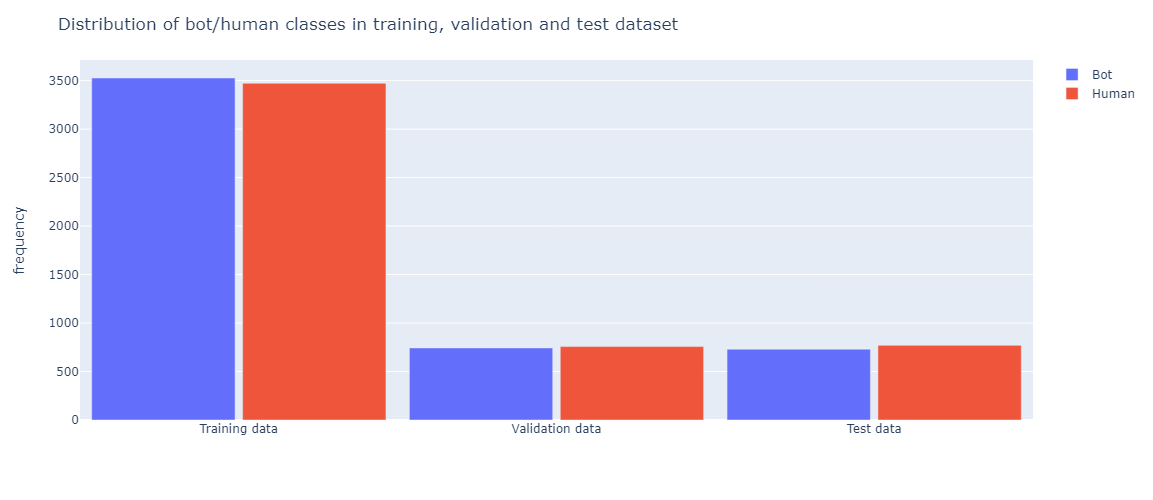

In [163]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### followers_count

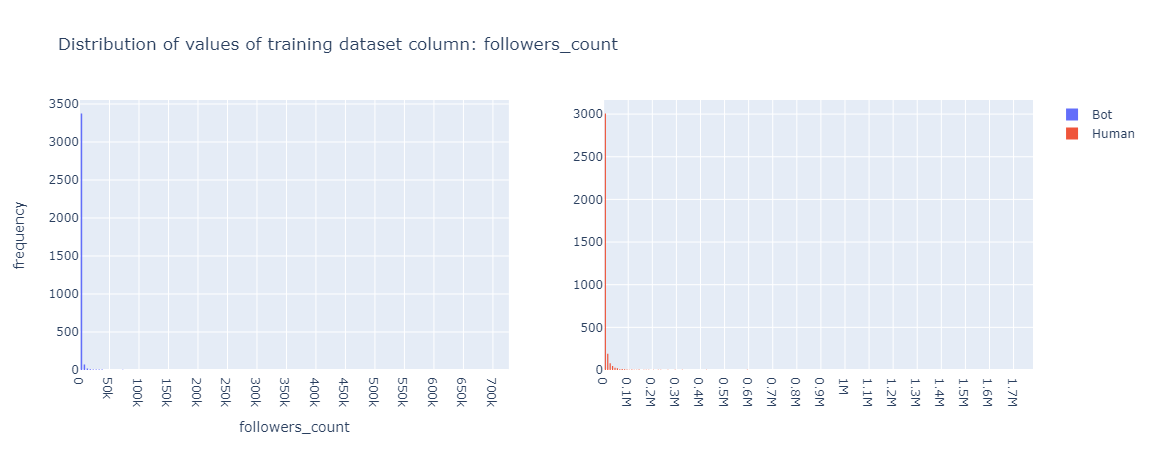

In [164]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=50000, range=[0, max(train_users_data.loc[train_users_data['label']==1,'followers_count'])+25000]),
    xaxis2=dict(showgrid=True, dtick=100000, range=[0, max(train_users_data.loc[train_users_data['label']==0,'followers_count'])+50000]),
    yaxis=dict(showgrid=True))

fig.show()

In [165]:
len(train_users_data[(train_users_data['label']==1)])

3527

In [166]:
len(train_users_data[(train_users_data['label']==0)])

3473

In [167]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_users_data.loc[train_users_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_users_data.loc[train_users_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_users_data[((train_users_data['label']==1) & (train_users_data['followers_count'] < percentile_99_bots)) | ((train_users_data['label']==0) & (train_users_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_users_data[(train_users_data['label']==1) & (train_users_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_users_data[(train_users_data['label']==0) & (train_users_data['followers_count'] < percentile_99_humans)]

In [168]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

#### following_count

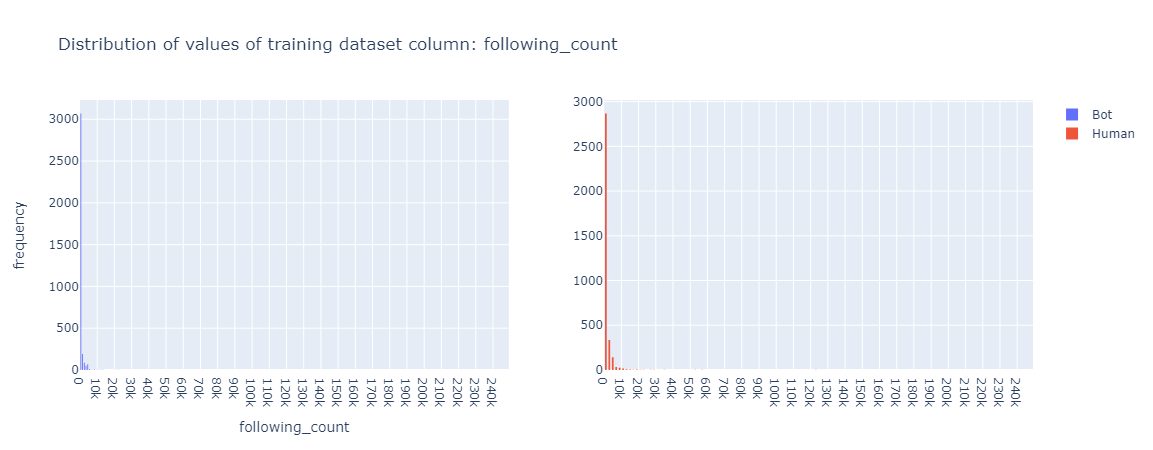

In [169]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000, range=[0, max(train_users_data['following_count'])+5000]),
    xaxis2=dict(showgrid=True, dtick=10000, range=[0, max(train_users_data['following_count'])+5000]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

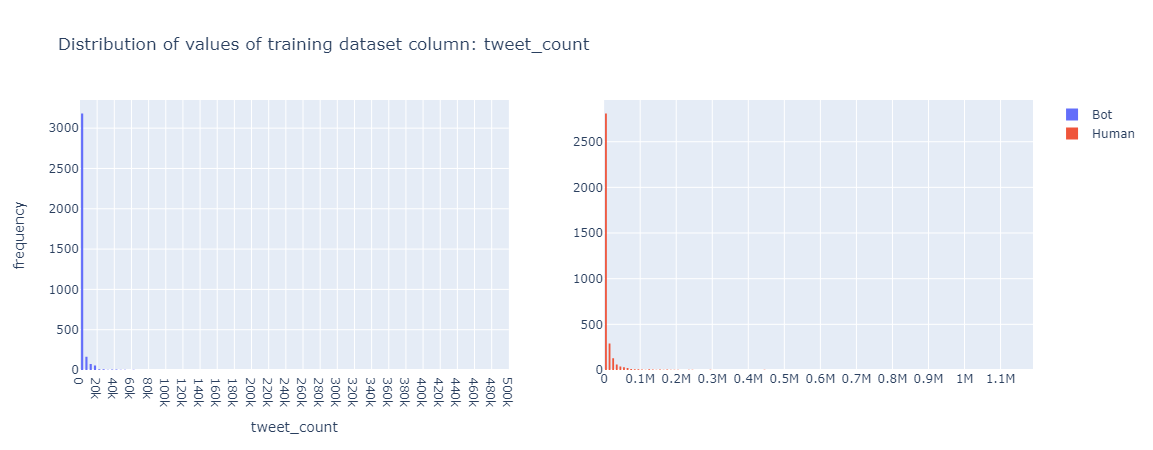

In [170]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

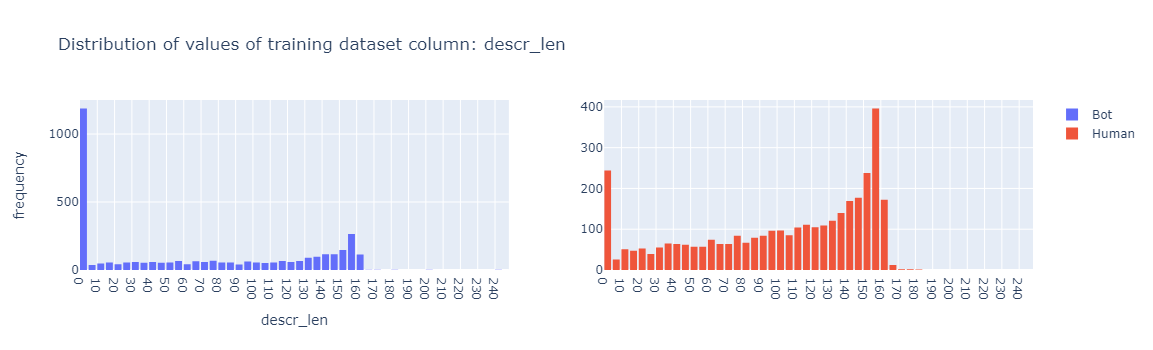

In [171]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(train_users_data['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(train_users_data['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

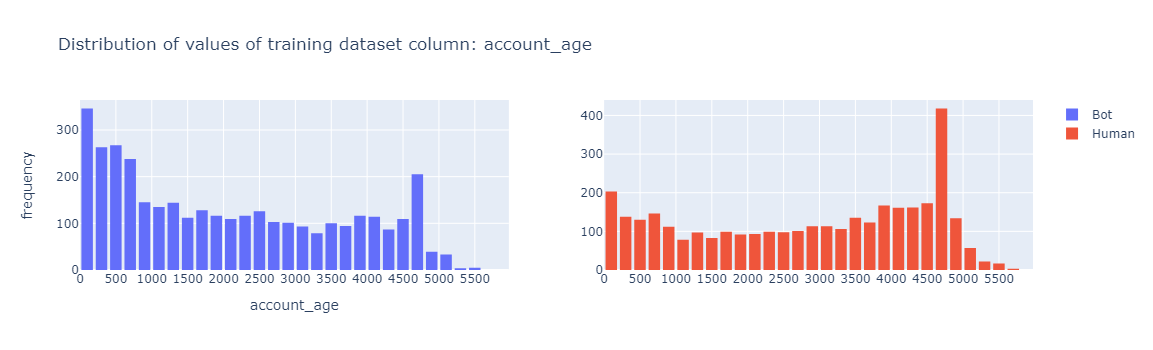

In [172]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_users_data.loc[train_users_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_users_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_users_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

In [173]:
len(train_users_data)

7000

### Filter to have the same number of records for each class - part II

In [174]:
train_users_data = filter_df_for_balanced_classes(train_users_data, bot_label_value=1, human_label_value=0)
val_users_data = filter_df_for_balanced_classes(val_users_data, bot_label_value=1, human_label_value=0)
test_users_data = filter_df_for_balanced_classes(test_users_data, bot_label_value=1, human_label_value=0)

Number of bots:  3473
Number of human users:  3473
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


#### First drop columns in dataframes where there are same value in whole columns in training dataset

In [175]:
same_data_columns = list(train_users_data.columns[train_users_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [176]:
train_users_data = train_users_data.drop(same_data_columns, axis=1)

val_users_data = val_users_data.drop(same_data_columns, axis=1)
test_users_data = test_users_data.drop(same_data_columns, axis=1)

### Standardize data by column range of training set

In [177]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

In [178]:
# columns_to_standardize = ['followers_count', 'following_count', 'tweet_count', 'descr_len', 'account_age']
columns_to_standardize = list(train_users_data.columns)
columns_to_standardize.remove('label')
columns_to_standardize.remove('id')

In [179]:
for column_name in columns_to_standardize:
    mean_training = train_users_data[column_name].mean()
    std_training = train_users_data[column_name].std()
    print(column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)
    print()

    train_users_data = standardize_column(train_users_data, column_name, mean_training, std_training)
    val_users_data = standardize_column(val_users_data, column_name, mean_training, std_training)
    test_users_data = standardize_column(test_users_data, column_name, mean_training, std_training)

followers_count
mean_training =  6208.796717535272
std_training =  44145.842669630874

tweet_count
mean_training =  6595.194212496401
std_training =  33286.69197462025

following_count
mean_training =  1259.0381514540743
std_training =  6144.786564521689

account_age
mean_training =  2443.6521739130435
std_training =  1640.571178505393

descr_len
mean_training =  84.77094730780306
std_training =  59.6092442340293



## Correlation

In [180]:
sns.set(font_scale=2)

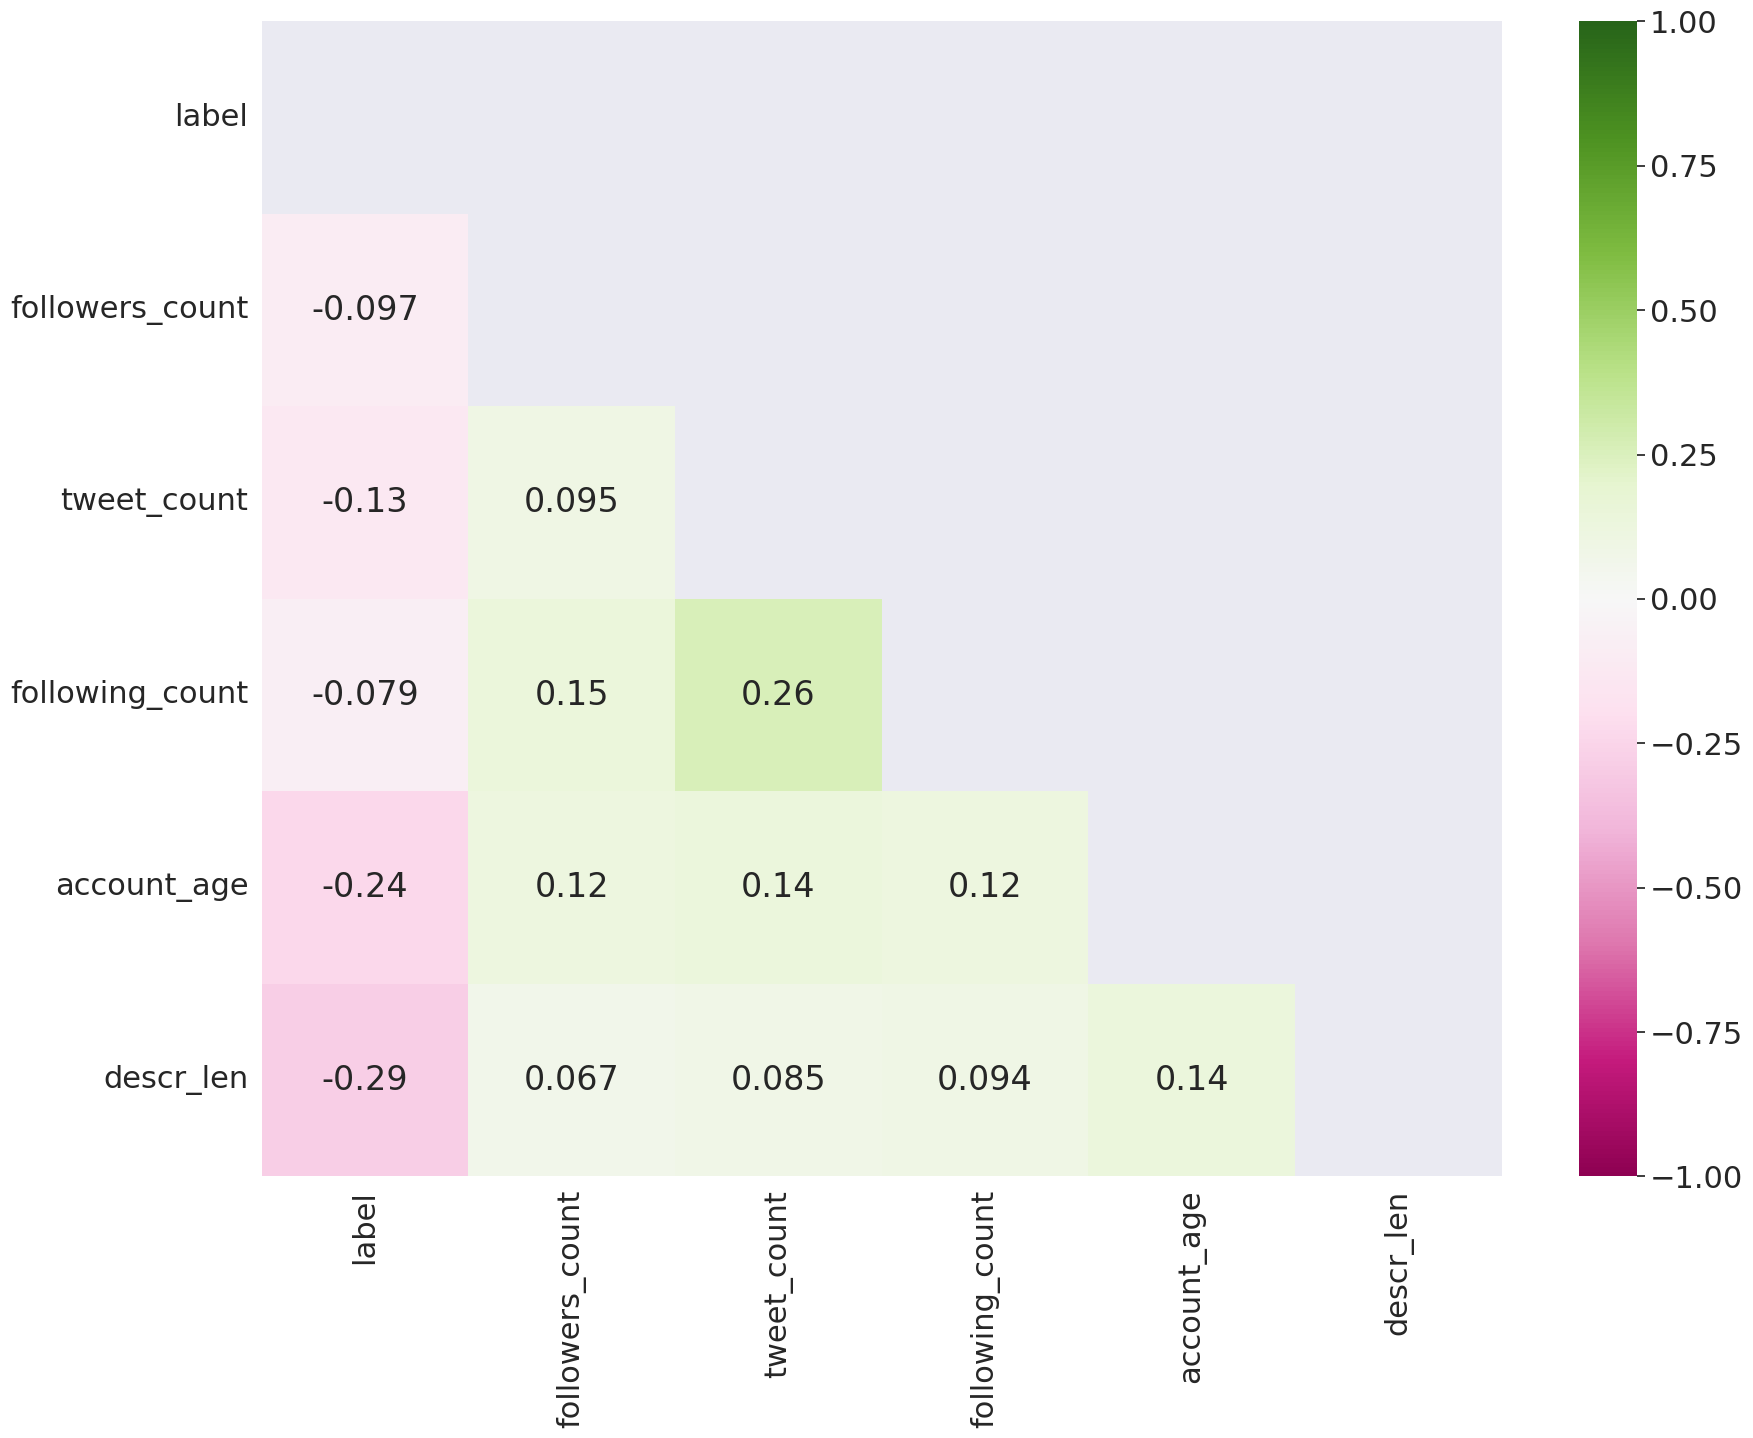

In [181]:
corr_threshold = 0.52
corr = train_users_data.drop(['id'], axis=1).corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_users_data:
    if (column != 'id'):
        for col in train_users_data:
            if (col != 'id'):
                if abs(lower_tri[column][col]) > corr_threshold:
                    high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [182]:
sns.set(font_scale=1)

In [183]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [184]:
# train_users_data = train_users_data.drop(['listed_count'], axis=1)
# val_users_data = val_users_data.drop(['listed_count'], axis=1)
# test_users_data = test_users_data.drop(['listed_count'], axis=1)

# train_users_data = train_users_data.drop(['has_description'], axis=1)
# val_users_data = val_users_data.drop(['has_description'], axis=1)
# test_users_data = test_users_data.drop(['has_description'], axis=1)

In [185]:
train_users_data

,label,id,followers_count,tweet_count,following_count,account_age,descr_len
6625,0.0,1214018601683836928,-0.128094,-0.192545,-0.113436,-1.001878,1.043950
2489,0.0,109927809,-0.078032,-0.044047,0.038726,1.209547,1.111053
9919,0.0,2325624539,-0.092643,-0.120715,0.608965,0.315346,1.262037
6964,1.0,1362188147250061315,-0.140643,-0.198103,-0.196107,-1.250572,-1.422111
3467,0.0,1105810614935531521,-0.133711,-0.059549,-0.178369,-0.819624,0.993622
...,...,...,...,...,...,...,...
3325,0.0,1059189764,-0.128705,-0.129968,0.053210,0.557335,1.262037
1881,0.0,235022253,-0.116065,-0.046150,0.438414,1.001083,1.060726
4861,0.0,3053537383,-0.140371,-0.198013,-0.189598,0.078234,-0.616867
1175,0.0,4348813577,-0.139805,-0.197232,-0.155423,-0.090000,-1.422111


### Split users data for input and output

In [186]:
train_users_data_X = train_users_data.drop(['label'], axis=1)
train_users_data_Y = pd.concat([train_users_data['label']], axis=1)
val_users_data_X = val_users_data.drop(['label'], axis=1)
val_users_data_Y = pd.concat([val_users_data['label']], axis=1)
test_users_data_X = test_users_data.drop(['label'], axis=1)
test_users_data_Y = pd.concat([test_users_data['label']], axis=1)

# Tweets data

------

## Loading data

##### Loading users data to retriew label to add for each tweet

In [187]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
users_table_id = project_id + "." + BQ_TABLE_USERS

In [ ]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

##### Load tweets data 

In [ ]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"
tweets_table_name = "tweets"
BQ_TABLE_TWEETS = dataset_name + "." + tweets_table_name
tweets_table_id = project_id + "." + BQ_TABLE_TWEETS

In [190]:
# comma-separated string of user IDs from users dataframe
users_df0 = pd.DataFrame(users_df1).copy()
users_df0['id'] = users_df0['id'].astype(str)
user_ids = users_df0['id'].to_list()

# # SQL query to select records from the 'tweets' table
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_TWEETS} WHERE CAST(author_id AS STRING) IN ({str(user_ids)[1:-1]})"""

tweets_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [191]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [192]:
len(tweets_df1)

426163

#### Append to tweets dataset author label (1/0, bot/human)

In [193]:
user_id_label_dict = users_df1.set_index('id')['label'].to_dict()
tweets_df1['author_label'] = tweets_df1['author_id'].map(user_id_label_dict)

In [194]:
# tweets_df1

In [195]:
org_tweet_df = pd.DataFrame(tweets_df1).copy()
tweets_df = pd.DataFrame(org_tweet_df).copy()

In [196]:
tweets_df.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'withheld', 'copyright_infringement', 'is_reply', 'geo_tagged',
       'latitude', 'longitude', 'conversation_id', 'reply_settings',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'any_polls_attached', 'any_media_attached', 'possibly_sensitive',
       'has_referenced_tweets', 'media_attached', 'no_cashtags', 'no_mentions',
       'no_user_mentions', 'user_mentions', 'no_urls', 'contains_images',
       'contains_annotations', 'no_hashtags', 'hashtags',
       'context_annotations_domain_id', 'context_annotations_domain_name',
       'context_annotations_entity_id', 'context_annotations_entity_name',
       'author_label'],
      dtype='object')

In [197]:
len(tweets_df)

426163

In [198]:
tweets_df

,id,author_id,created_at,org_text,text,source,withheld,copyright_infringement,is_reply,geo_tagged,latitude,longitude,conversation_id,reply_settings,retweet_count,reply_count,like_count,quote_count,any_polls_attached,any_media_attached,possibly_sensitive,has_referenced_tweets,media_attached,no_cashtags,no_mentions,no_user_mentions,user_mentions,no_urls,contains_images,contains_annotations,no_hashtags,hashtags,context_annotations_domain_id,context_annotations_domain_name,context_annotations_entity_id,context_annotations_entity_name,author_label
0,t871667974888988672,18456141,1496656814,10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News,things in tech you need to know today | via biuktech tech morning news,Hootsuite,False,False,False,False,NaN,NaN,871667974888988672,None,2,0,1,0,False,False,False,False,False,0,0,0,[],1,False,False,3,"[{'tagname': 'Tech'}, {'tagname': 'Morning'}, {'tagname': 'News'}]",<NA>,None,<NA>,None,human
1,t1451246919590760454,50338306,1634839203,Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3,shannon minter is a groundbreaking transgender civil rights attorney who argued successfully before the us supreme court he serves as the legal director of the national center for lesbian rights nclr,Sked Social,False,False,False,False,NaN,NaN,1451246919590760454,None,0,0,0,0,False,False,False,False,False,0,0,0,[],1,False,False,0,[],<NA>,None,<NA>,None,human
2,t1464338171211227141,50338306,1637960400,"For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes. https://t.co/NJ4CkorXuy",for the lgbtq community the annual endoftheyear holiday season traditionally kicks off with costumed halloween parties at clubs and homes,Sked Social,False,False,False,False,NaN,NaN,1464338171211227141,None,0,0,0,0,False,False,False,False,False,0,0,0,[],1,False,False,0,[],<NA>,None,<NA>,None,human
3,t1486051245441929219,50338306,1643137201,"André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21",andre leon talley an icon of fashion journalism has died at the age of best known for his roles at vogue as creative director and editoratlarge which spanned from the s to,Sked Social,False,False,False,False,NaN,NaN,1486051245441929219,None,0,0,0,0,False,False,False,False,False,0,0,0,[],1,False,False,0,[],<NA>,None,<NA>,None,human
4,t1449051082244739075,106526969,1634315674,"A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg",a month after abbott issued a safety notice describing a defect that could cause some of its covid tests to return false positive results the fda has upgraded the issue into a class i recall,Twitter Web App,False,False,False,False,NaN,NaN,1449051082244739075,None,1,0,0,0,False,False,False,False,False,0,0,0,[],1,False,False,1,[{'tagname': 'COVID'}],<NA>,None,<NA>,None,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426158,t1494355678781374464,1298362221731274752,1645117132,Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb,looking for a minimalist logo design get your quote logo icon company minimalist simple design 

# Data preparation

In [199]:
def drop_columns(df, columns):
    for column_name in columns:
        curr_df_all_cols = df.columns
        if column_name in curr_df_all_cols:
            df = df.drop([column_name], axis=1)
    return df

In [200]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

### Null and NaN statistics

In [201]:
for col_name in tweets_df:
    count1 = pd.isnull(tweets_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
author_id: 0
created_at: 0
org_text: 0
text: 0
source: 0
withheld: 0
copyright_infringement: 0
is_reply: 0
geo_tagged: 0
latitude: 422884
longitude: 422884
conversation_id: 0
reply_settings: 420428
retweet_count: 0
reply_count: 0
like_count: 0
quote_count: 0
any_polls_attached: 0
any_media_attached: 0
possibly_sensitive: 0
has_referenced_tweets: 0
media_attached: 0
no_cashtags: 0
no_mentions: 0
no_user_mentions: 0
user_mentions: 0
no_urls: 0
contains_images: 0
contains_annotations: 0
no_hashtags: 0
hashtags: 0
context_annotations_domain_id: 426163
context_annotations_domain_name: 426163
context_annotations_entity_id: 426163
context_annotations_entity_name: 426163
author_label: 0


In [202]:
for col_name in tweets_df:
    count1 = pd.isnull(tweets_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
author_id: 0
created_at: 0
org_text: 0
text: 0
source: 0
withheld: 0
copyright_infringement: 0
is_reply: 0
geo_tagged: 0
latitude: 422884
longitude: 422884
conversation_id: 0
reply_settings: 420428
retweet_count: 0
reply_count: 0
like_count: 0
quote_count: 0
any_polls_attached: 0
any_media_attached: 0
possibly_sensitive: 0
has_referenced_tweets: 0
media_attached: 0
no_cashtags: 0
no_mentions: 0
no_user_mentions: 0
user_mentions: 0
no_urls: 0
contains_images: 0
contains_annotations: 0
no_hashtags: 0
hashtags: 0
context_annotations_domain_id: 426163
context_annotations_domain_name: 426163
context_annotations_entity_id: 426163
context_annotations_entity_name: 426163
author_label: 0


### reply_settings

Twitter documentation for that field mantions that: If the field isn’t specified, it will default to everyone.

In [203]:
set(tweets_df.loc[tweets_df['reply_settings'].notna()]['reply_settings'])

{'everyone', 'following', 'mentionedUsers'}

In [204]:
set(tweets_df['reply_settings'])

{None, 'everyone', 'following', 'mentionedUsers'}

#### Replace not specified value / None with 'everyone'

In [205]:
tweets_df['reply_settings'].fillna('everyone', inplace=True)

#### Remove columns with most lacking value

In [206]:
most_nan_columns = ['context_annotations_domain_id',
                    'context_annotations_domain_name',
                    'context_annotations_entity_id',
                    'context_annotations_entity_name',
                    'latitude',
                    'longitude']
tweets_df = drop_columns(tweets_df, most_nan_columns)

## Encoding of non-numeric information which will be used by model

#### Encode boolean columns

In [207]:
boolean_columns  = ['withheld',
                    'copyright_infringement',
                    'is_reply',
                    'geo_tagged',
                    'any_polls_attached',
                    'any_media_attached',
                    'possibly_sensitive',
                    'has_referenced_tweets',
                    'media_attached',
                    'contains_images',
                    'contains_annotations']

In [208]:
# Remap the values of the dataframe
for col_name in boolean_columns:
    tweets_df[col_name] = tweets_df[col_name].map({True:1,False:0})
    
# Remap label values human/bot for 0/1
label_col = "author_label"
tweets_df[label_col] = tweets_df[label_col].map({"human":0,"bot":1})

#### Encode reply_settings categorical column

In [209]:
reply_settings_dict = {'everyone' : 0, 
                       'following' : 1, 
                       'mentionedUsers' : 2}

In [210]:
tweets_df['reply_settings'] = tweets_df['reply_settings'].map(reply_settings_dict)

In [211]:
set(tweets_df['reply_settings'])

{0, 1, 2}

In [212]:
tweets_df

,id,author_id,created_at,org_text,text,source,withheld,copyright_infringement,is_reply,geo_tagged,conversation_id,reply_settings,retweet_count,reply_count,like_count,quote_count,any_polls_attached,any_media_attached,possibly_sensitive,has_referenced_tweets,media_attached,no_cashtags,no_mentions,no_user_mentions,user_mentions,no_urls,contains_images,contains_annotations,no_hashtags,hashtags,author_label
0,t871667974888988672,18456141,1496656814,10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News,things in tech you need to know today | via biuktech tech morning news,Hootsuite,0,0,0,0,871667974888988672,0,2,0,1,0,0,0,0,0,0,0,0,0,[],1,0,0,3,"[{'tagname': 'Tech'}, {'tagname': 'Morning'}, {'tagname': 'News'}]",0
1,t1451246919590760454,50338306,1634839203,Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3,shannon minter is a groundbreaking transgender civil rights attorney who argued successfully before the us supreme court he serves as the legal director of the national center for lesbian rights nclr,Sked Social,0,0,0,0,1451246919590760454,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0
2,t1464338171211227141,50338306,1637960400,"For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes. https://t.co/NJ4CkorXuy",for the lgbtq community the annual endoftheyear holiday season traditionally kicks off with costumed halloween parties at clubs and homes,Sked Social,0,0,0,0,1464338171211227141,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0
3,t1486051245441929219,50338306,1643137201,"André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21",andre leon talley an icon of fashion journalism has died at the age of best known for his roles at vogue as creative director and editoratlarge which spanned from the s to,Sked Social,0,0,0,0,1486051245441929219,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0
4,t1449051082244739075,106526969,1634315674,"A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg",a month after abbott issued a safety notice describing a defect that could cause some of its covid tests to return false positive results the fda has upgraded the issue into a class i recall,Twitter Web App,0,0,0,0,1449051082244739075,0,1,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,1,[{'tagname': 'COVID'}],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426158,t1494355678781374464,1298362221731274752,1645117132,Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb,looking for a minimalist logo design get your quote logo icon company minimalist simple design premium unique sundayvibes askfft sundaymorning haiti pecan gaskin wilt mahomes ahmed fnatic miami newtot grass,Twitter Web App,0,0,0,0,1494355678781374464,0,0,0,0,0,0,0,0,0,0,0,0,0,[],2,0,0,21,"[{'tagname': 'logo'}, {'tagname': 'icon'}, {'tagname': 'company'}, {'tagname': 'minimalist'}, {'tagname': 'simple'}, {'tagname': 'design'}, {'tagname': 'premium'}, {'tagname': 'unique'}, {'tagname': 'sundayvibes'}, {'tagname': 'AskFFT'}, {'tagname': 'SundayMorning'}, {'tagname': 'Haiti'}, {'tagname': 'Pecan'}, {'tagname': 'Gaskin'}, {'tagname': 'Wilt'}, {'tagname':

### Extract some information from dataframe to new columns

#### Tweet length

In [213]:
tweets_df['cleaned_tweet_len'] = tweets_df['text'].apply(len).astype(float)
tweets_df['org_tweet_len'] = tweets_df['org_text'].apply(len).astype(float)

In [214]:
tweets_df

,id,author_id,created_at,org_text,text,source,withheld,copyright_infringement,is_reply,geo_tagged,conversation_id,reply_settings,retweet_count,reply_count,like_count,quote_count,any_polls_attached,any_media_attached,possibly_sensitive,has_referenced_tweets,media_attached,no_cashtags,no_mentions,no_user_mentions,user_mentions,no_urls,contains_images,contains_annotations,no_hashtags,hashtags,author_label,cleaned_tweet_len,org_tweet_len
0,t871667974888988672,18456141,1496656814,10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News,things in tech you need to know today | via biuktech tech morning news,Hootsuite,0,0,0,0,871667974888988672,0,2,0,1,0,0,0,0,0,0,0,0,0,[],1,0,0,3,"[{'tagname': 'Tech'}, {'tagname': 'Morning'}, {'tagname': 'News'}]",0,70.0,102.0
1,t1451246919590760454,50338306,1634839203,Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3,shannon minter is a groundbreaking transgender civil rights attorney who argued successfully before the us supreme court he serves as the legal director of the national center for lesbian rights nclr,Sked Social,0,0,0,0,1451246919590760454,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0,199.0,253.0
2,t1464338171211227141,50338306,1637960400,"For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes. https://t.co/NJ4CkorXuy",for the lgbtq community the annual endoftheyear holiday season traditionally kicks off with costumed halloween parties at clubs and homes,Sked Social,0,0,0,0,1464338171211227141,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0,137.0,167.0
3,t1486051245441929219,50338306,1643137201,"André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21",andre leon talley an icon of fashion journalism has died at the age of best known for his roles at vogue as creative director and editoratlarge which spanned from the s to,Sked Social,0,0,0,0,1486051245441929219,0,0,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,0,[],0,171.0,214.0
4,t1449051082244739075,106526969,1634315674,"A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg",a month after abbott issued a safety notice describing a defect that could cause some of its covid tests to return false positive results the fda has upgraded the issue into a class i recall,Twitter Web App,0,0,0,0,1449051082244739075,0,1,0,0,0,0,0,0,0,0,0,0,0,[],1,0,0,1,[{'tagname': 'COVID'}],0,190.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426158,t1494355678781374464,1298362221731274752,1645117132,Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb,looking for a minimalist logo design get your quote logo icon company minimalist simple design premium unique sundayvibes askfft sundaymorning haiti pecan gaskin wilt mahomes ahmed fnatic miami newtot grass,Twitter Web App,0,0,0,0,1494355678781374464,0,0,0,0,0,0,0,0,0,0,0,0,0,[],2,0,0,21,"[{'tagname': 'logo'}, {'tagname': 'icon'}, {'tagname': 'company'}, {'tagname': 'minimalist'}, {'tagname': 'simple'}, {'tagname': 'design'}, {'tagname': 'premium'}, {'tagname': 'unique'}, {'tagname': 'sundayvibes'}, {'tagname': 'AskFFT'}, {'tagname': 'SundayMorning'}, 

#### Time of the date (in min, UTC)

In [215]:
def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

def get_time_in_minutes(unix_time):
    h = convert_unixtime_to_datetime(unix_time).hour
    m = convert_unixtime_to_datetime(unix_time).minute
    all_minutes = (h * 60) + m
    return all_minutes

In [216]:
tweets_df['time_of_creation'] = tweets_df.apply(lambda x:  get_time_in_minutes(x.created_at), axis=1).astype(float)

#### Add days different between tweets, days_since_prev_tweet

In [217]:
tweets_df['creation_date'] = tweets_df.apply(lambda x: convert_unixtime_to_datetime(x.created_at), axis=1)
tweets_df.sort_values(by=['author_id', 'creation_date'], inplace=True)

In [218]:
grouped = tweets_df.groupby('author_id')
tweets_df['days_since_prev_tweet'] = grouped['creation_date'].diff().dt.days
tweets_df['days_since_prev_tweet'].fillna(0, inplace=True)
tweets_df = tweets_df.drop(['creation_date'], axis=1)

In [219]:
# Revert to original order 
tweets_df.sort_index(inplace=True)

### Remove some leftover special characters

In [220]:
tweets_df['text'] = tweets_df['text'].str.replace('|', '', regex=False)

In [221]:
tweets_df.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'withheld', 'copyright_infringement', 'is_reply', 'geo_tagged',
       'conversation_id', 'reply_settings', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'any_polls_attached', 'any_media_attached',
       'possibly_sensitive', 'has_referenced_tweets', 'media_attached',
       'no_cashtags', 'no_mentions', 'no_user_mentions', 'user_mentions',
       'no_urls', 'contains_images', 'contains_annotations', 'no_hashtags',
       'hashtags', 'author_label', 'cleaned_tweet_len', 'org_tweet_len',
       'time_of_creation', 'days_since_prev_tweet'],
      dtype='object')

In [222]:
add_tweets_feature_shp_values = ['is_reply', 'time_of_creation', 'no_urls',
                                 'no_hashtags',  'org_tweet_len', 'no_mentions', 
                                 'any_media_attached', 'contains_annotations', 
                                 'has_referenced_tweets', 'possibly_sensitive', 
                                 'no_user_mentions']

In [223]:
col_to_leave =  ['id', 'author_id', 'text', 'days_since_prev_tweet', 'created_at'] + add_tweets_feature_shp_values
tweets_df = tweets_df[col_to_leave]

In [224]:
tweets_df.columns

Index(['id', 'author_id', 'text', 'days_since_prev_tweet', 'created_at',
       'is_reply', 'time_of_creation', 'no_urls', 'no_hashtags',
       'org_tweet_len', 'no_mentions', 'any_media_attached',
       'contains_annotations', 'has_referenced_tweets', 'possibly_sensitive',
       'no_user_mentions'],
      dtype='object')

## Data split for training, validation and testing of tweets data based on users data split

In [225]:
users_train_set_users_id = train_users_data['id']
users_val_set_users_id = val_users_data['id']
users_test_set_users_id = test_users_data['id']

In [226]:
train_tweets_data = tweets_df[tweets_df['author_id'].isin(users_train_set_users_id)]
val_tweets_data = tweets_df[tweets_df['author_id'].isin(users_val_set_users_id)]
test_tweets_data = tweets_df[tweets_df['author_id'].isin(users_test_set_users_id)]

In [227]:
train_tweets_data1 = pd.DataFrame(train_tweets_data).copy()
val_tweets_data1 = pd.DataFrame(val_tweets_data).copy()
test_tweets_data1 = pd.DataFrame(test_tweets_data).copy()

# Analysis

In [228]:
train_tweets_data.columns

Index(['id', 'author_id', 'text', 'days_since_prev_tweet', 'created_at',
       'is_reply', 'time_of_creation', 'no_urls', 'no_hashtags',
       'org_tweet_len', 'no_mentions', 'any_media_attached',
       'contains_annotations', 'has_referenced_tweets', 'possibly_sensitive',
       'no_user_mentions'],
      dtype='object')

In [229]:
columns_to_standardize = [  #'id', 
                            # 'author_id', 
                            # 'created_at',
                            # 'text', 
                            'days_since_prev_tweet', 
                            'is_reply',
                            'time_of_creation',
                            'no_urls',
                            'no_hashtags',
                            'org_tweet_len',
                            'no_mentions', 
                            'any_media_attached', 
                            'contains_annotations',
                            'has_referenced_tweets', 
                            'possibly_sensitive', 
                            'no_user_mentions']

#### Remove unnecessery columns

In [231]:
train_tweets_data.columns

Index(['id', 'author_id', 'text', 'days_since_prev_tweet', 'created_at',
       'is_reply', 'time_of_creation', 'no_urls', 'no_hashtags',
       'org_tweet_len', 'no_mentions', 'any_media_attached',
       'contains_annotations', 'has_referenced_tweets', 'possibly_sensitive',
       'no_user_mentions'],
      dtype='object')

In [233]:
unnecessery_col_to_remove = [# 'id',
                             #'author_id',    # need later
                             #'created_at',   # nead to sort tweets per user later
                             'org_text',
                             'source',
                             'conversation_id',
                             'user_mentions',
                             'hashtags',
                             'created_at_datetime']

In [234]:
train_tweets_data = drop_columns(train_tweets_data, unnecessery_col_to_remove)
val_tweets_data = drop_columns(val_tweets_data, unnecessery_col_to_remove)
test_tweets_data = drop_columns(test_tweets_data, unnecessery_col_to_remove)

In [235]:
columns_to_standardize = [ col for col in columns_to_standardize if col in train_tweets_data.columns]

### Data type conversion (to float)

In [236]:
for column_name in columns_to_standardize:
    train_tweets_data[column_name] = train_tweets_data[column_name].astype(float)
    val_tweets_data[column_name] = val_tweets_data[column_name].astype(float)
    test_tweets_data[column_name] = test_tweets_data[column_name].astype(float)

### Standardize other tweets data by column range of training set

In [237]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

#### Standardize

In [238]:
for column_name in columns_to_standardize:
    mean_training = train_tweets_data[column_name].mean()
    std_training = train_tweets_data[column_name].std()
    print(column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)
    print()
    
    train_tweets_data = standardize_column(train_tweets_data, column_name, mean_training, std_training)
    val_tweets_data = standardize_column(val_tweets_data, column_name, mean_training, std_training)
    test_tweets_data = standardize_column(test_tweets_data, column_name, mean_training, std_training)

days_since_prev_tweet
mean_training =  10.150619688444115
std_training =  83.86048614893724

is_reply
mean_training =  0.15228149709017305
std_training =  0.35929412990954285

time_of_creation
mean_training =  832.0637669213666
std_training =  379.5939656071315

no_urls
mean_training =  0.5035845212495471
std_training =  0.5677704754324685

no_hashtags
mean_training =  1.8141632627286233
std_training =  3.313255545275742

org_tweet_len
mean_training =  171.79513887734856
std_training =  76.81292827031992

no_mentions
mean_training =  0.011390036460081694
std_training =  0.19828870716436517

any_media_attached
mean_training =  0.005327758519262024
std_training =  0.07279691697847115

contains_annotations
mean_training =  0.006201869867088545
std_training =  0.07850749748981518

has_referenced_tweets
mean_training =  0.0032837338846106547
std_training =  0.05720980557962361

possibly_sensitive
mean_training =  0.004453647171435504
std_training =  0.06658698772772152

no_user_mentions
mea

# Text preprocessing

#### Create backup column for text before processing

In [239]:
train_tweets_data.loc[:, 'text_np'] = train_tweets_data['text']

In [240]:
val_tweets_data.loc[:, 'text_np'] = val_tweets_data['text']

In [241]:
test_tweets_data.loc[:, 'text_np'] = test_tweets_data['text']

## Remove stop words and tokenize tweet text and use word embeddings

In [242]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [243]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/63/78/ed291d95116695b8b5d7469a931d7c2e83d942df0853915ee504cee98bcf/regex-2023.8.8-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached regex-2023.8.8-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached regex-2023.8.8-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (758 kB)


In [244]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [245]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [246]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text'].apply(lambda text : word_tokenize(text))
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text'].apply(lambda text : word_tokenize(text))
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text'].apply(lambda text : word_tokenize(text))

### Remove stopwords

In [247]:
stop_words = stopwords.words('english')

In [248]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])

#### To not have additional spaces

In [249]:
train_tweets_data.loc[:, 'text'] = train_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
val_tweets_data.loc[:, 'text'] = val_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
test_tweets_data.loc[:, 'text'] = test_tweets_data['text_tk'].apply(lambda words : ' '.join(words))

### Word Embedding

In [250]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

#### For training set

In [251]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets_data['text'])
word_index = tokenizer.word_index

num_words = len(word_index) + 1  # adding 1 for padding token
embedding_dim = 100              # using GloVe 100-dimensional vectors

### Integer encode text

In [252]:
train_tweets_data.loc[:, 'text_seq'] = train_tweets_data['text'].apply(lambda text:  tokenizer.texts_to_sequences([text])[0])
val_tweets_data.loc[:, 'text_seq'] = val_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])
test_tweets_data.loc[:, 'text_seq'] = test_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])

### Pad encoded text to a max length 

In [253]:
max_length_train = train_tweets_data['text_seq'].apply(len).max()
max_length_val = val_tweets_data['text_seq'].apply(len).max()
max_length_test = test_tweets_data['text_seq'].apply(len).max()

In [254]:
max_length_train

76

In [255]:
max_length_val

37

In [256]:
max_length_test

36

In [257]:
train_tweets_data['text_seq'].apply(len).mean()

14.39626491888712

In [258]:
val_tweets_data['text_seq'].apply(len).mean()

12.773751671504517

In [259]:
test_tweets_data['text_seq'].apply(len).mean()

12.53067008570079

In [260]:
max_length = 15  # max_length_train

In [261]:
train_tweets_data.loc[:, 'text_seq_ps'] = train_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
val_tweets_data.loc[:, 'text_seq_ps'] = val_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
test_tweets_data.loc[:, 'text_seq_ps'] = test_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))

#### Load GloVe embedding

In [262]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [263]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Creating a weight matrix for words

In [264]:
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Correlation of numeric tweets data

In [265]:
sns.set(font_scale=1.5)

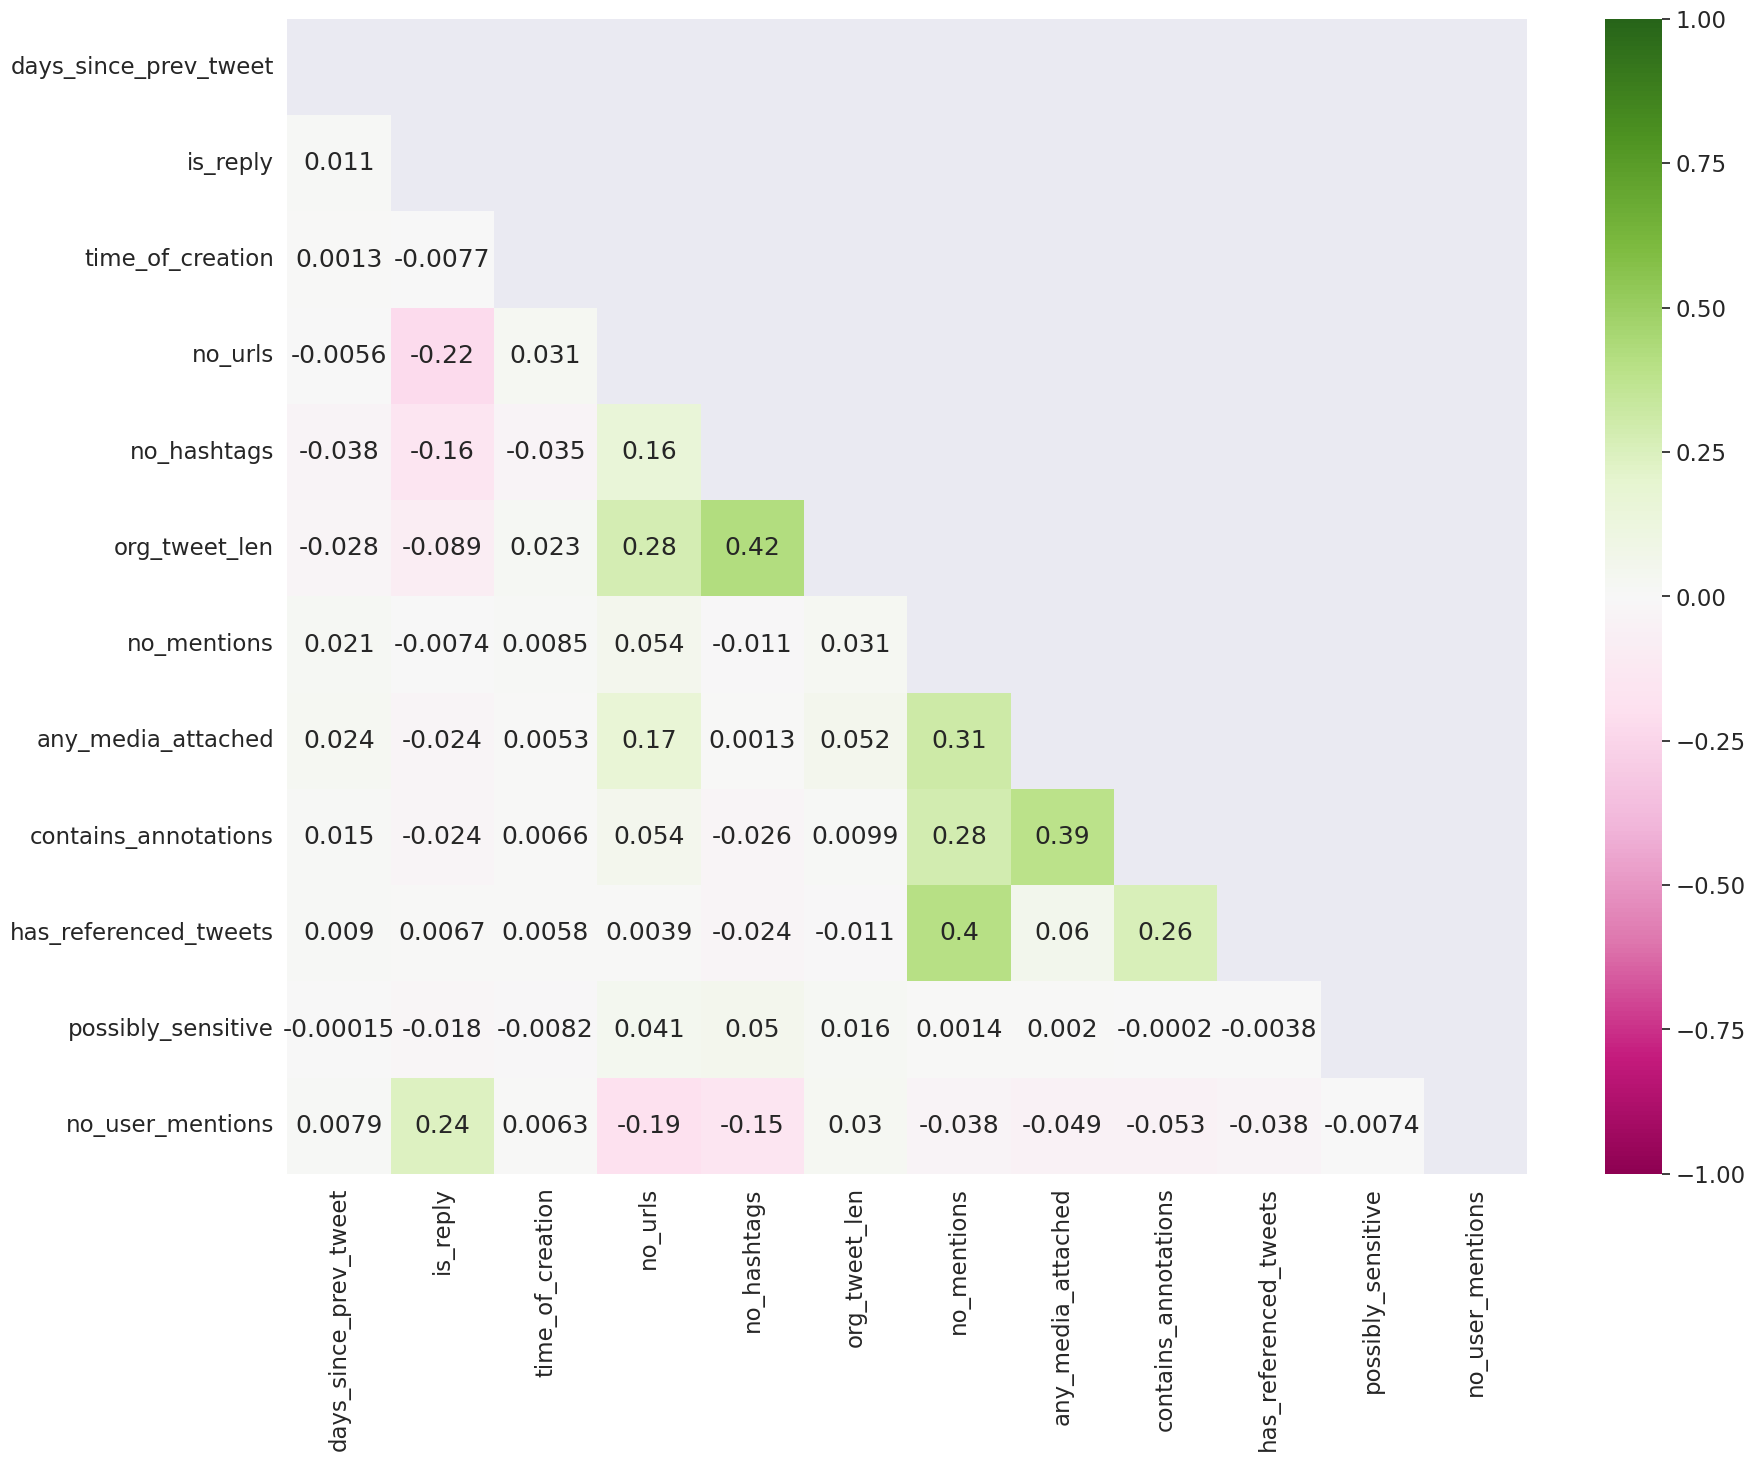

In [266]:
corr_threshold = 0.52
corr = train_tweets_data[columns_to_standardize].corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_tweets_data[columns_to_standardize]:
    for col in train_tweets_data[columns_to_standardize]:
        if abs(lower_tri[column][col]) > corr_threshold:
            high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [267]:
sns.set(font_scale=1)

In [268]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [269]:
# train_tweets_data = train_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [270]:
# val_tweets_data = val_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [271]:
# test_tweets_data = test_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

## Split tweets data for input and output

#### And convert inputs to tensors

In [273]:
train_tweets_data.columns

Index(['id', 'author_id', 'text', 'days_since_prev_tweet', 'created_at',
       'is_reply', 'time_of_creation', 'no_urls', 'no_hashtags',
       'org_tweet_len', 'no_mentions', 'any_media_attached',
       'contains_annotations', 'has_referenced_tweets', 'possibly_sensitive',
       'no_user_mentions', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'],
      dtype='object')

In [282]:
compact_train_tweets_text_data = []
compact_train_tweets_add_feat_data = []
for author_id, group in train_tweets_data.groupby('author_id'):
    group = group.sort_values('created_at', ascending=False)
    author_tweets_text = []
    author_tweets_add_feat = []
    for index, row in group.iterrows():
        row_arr = []
        row_arr.append(row['days_since_prev_tweet'])
        row_arr.append(row['is_reply'])
        row_arr.append(row['time_of_creation'])
        row_arr.append(row['no_urls'])
        row_arr.append(row['no_hashtags'])
        row_arr.append(row['org_tweet_len'])
        row_arr.append(row['no_mentions'])
        row_arr.append(row['any_media_attached'])
        row_arr.append(row['contains_annotations'])
        row_arr.append(row['has_referenced_tweets'])
        row_arr.append(row['possibly_sensitive'])
        row_arr.append(row['no_user_mentions'])
        author_tweets_add_feat.append(row_arr)
        author_tweets_text.append(row['text_seq_ps'][0])
    compact_train_tweets_text_data.append(author_tweets_text)
    compact_train_tweets_add_feat_data.append(author_tweets_add_feat)
    
compact_train_tweets_text_data = np.array(compact_train_tweets_text_data)
compact_train_tweets_add_feat_data = np.array(compact_train_tweets_add_feat_data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [283]:
compact_val_tweets_text_data = []
compact_val_tweets_add_feat_data = []
for author_id, group in val_tweets_data.groupby('author_id'):
    group = group.sort_values('created_at', ascending=False)
    author_tweets_text = []
    author_tweets_add_feat = []
    for index, row in group.iterrows():
        row_arr = []
        row_arr.append(row['days_since_prev_tweet'])
        row_arr.append(row['is_reply'])
        row_arr.append(row['time_of_creation'])
        row_arr.append(row['no_urls'])
        row_arr.append(row['no_hashtags'])
        row_arr.append(row['org_tweet_len'])
        row_arr.append(row['no_mentions'])
        row_arr.append(row['any_media_attached'])
        row_arr.append(row['contains_annotations'])
        row_arr.append(row['has_referenced_tweets'])
        row_arr.append(row['possibly_sensitive'])
        row_arr.append(row['no_user_mentions'])
        author_tweets_add_feat.append(row_arr)
        author_tweets_text.append(row['text_seq_ps'][0])
    compact_val_tweets_text_data.append(author_tweets_text)
    compact_val_tweets_add_feat_data.append(author_tweets_add_feat)
    
compact_val_tweets_text_data = np.array(compact_val_tweets_text_data)
compact_val_tweets_add_feat_data = np.array(compact_val_tweets_add_feat_data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [284]:
compact_test_tweets_text_data = []
compact_test_tweets_add_feat_data = []
for author_id, group in test_tweets_data.groupby('author_id'):
    group = group.sort_values('created_at', ascending=False)
    author_tweets_text = []
    author_tweets_add_feat = []
    for index, row in group.iterrows():
        row_arr = []
        row_arr.append(row['days_since_prev_tweet'])
        row_arr.append(row['is_reply'])
        row_arr.append(row['time_of_creation'])
        row_arr.append(row['no_urls'])
        row_arr.append(row['no_hashtags'])
        row_arr.append(row['org_tweet_len'])
        row_arr.append(row['no_mentions'])
        row_arr.append(row['any_media_attached'])
        row_arr.append(row['contains_annotations'])
        row_arr.append(row['has_referenced_tweets'])
        row_arr.append(row['possibly_sensitive'])
        row_arr.append(row['no_user_mentions'])
        author_tweets_add_feat.append(row_arr)
        author_tweets_text.append(row['text_seq_ps'][0])
    compact_test_tweets_text_data.append(author_tweets_text)
    compact_test_tweets_add_feat_data.append(author_tweets_add_feat)
    
compact_test_tweets_text_data = np.array(compact_test_tweets_text_data)
compact_test_tweets_add_feat_data = np.array(compact_test_tweets_add_feat_data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [285]:
# train_tweets_add_feat_data_X = tf.convert_to_tensor(train_tweets_data.drop(['id', 'author_id', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
# train_tweets_text_data_X = train_tweets_data['text_seq_ps'].apply(lambda x: x[0])
# train_tweets_text_data_X_tensor = tf.convert_to_tensor(train_tweets_text_data_X.tolist(), dtype=tf.float32)

# val_tweets_add_feat_data_X = tf.convert_to_tensor(val_tweets_data.drop(['id', 'author_id', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
# val_tweets_text_data_X = val_tweets_data['text_seq_ps'].apply(lambda x: x[0])
# val_tweets_text_data_X_tensor = tf.convert_to_tensor(val_tweets_text_data_X.tolist(), dtype=tf.float32)

# test_tweets_add_feat_data_X = tf.convert_to_tensor(test_tweets_data.drop(['id', 'author_id', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
# test_tweets_text_data_X = test_tweets_data['text_seq_ps'].apply(lambda x: x[0])
# test_tweets_text_data_X_tensor = tf.convert_to_tensor(test_tweets_text_data_X.tolist(), dtype=tf.float32)

## Reformat tweets data

In [301]:
compact_train_tweets_text_data.shape

(6946,)

In [302]:
np.array(compact_train_tweets_text_data[0]).shape

(66, 15)

In [303]:
max_l = 0
for arr_user_tweets_feat in compact_train_tweets_text_data:
    curr = np.array(arr_user_tweets_feat).shape[0]
    if curr > max_l:
        max_l = curr
max_l

3397

In [304]:
max_user_tweets_num = 20 # max_l

In [305]:
compact_train_tweets_text_data_padded = pad_sequences(compact_train_tweets_text_data, maxlen=max_user_tweets_num, padding='post', truncating='post', dtype='float32')
compact_val_tweets_text_data_padded = pad_sequenc\es(compact_val_tweets_text_data, maxlen=max_user_tweets_num, padding='post', truncating='post', dtype='float32')
compact_test_tweets_text_data_padded = pad_sequences(compact_test_tweets_text_data, maxlen=max_user_tweets_num, padding='post', truncating='post', dtype='float32')
len(compact_train_tweets_text_data_padded)

6946

In [306]:
train_users_data_Y.shape

(6946, 1)

In [307]:
np.array(train_users_data_X).shape

(6946, 6)

In [312]:
np.array(compact_train_tweets_text_data_padded[0]).shape

(20, 15)

------
------

# DNN models

#### Function to load a saved neural network model

In [286]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [287]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [288]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [289]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, concatenate, Masking

In [290]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [291]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs, patience=50):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(metric='val_accuracy', mode = 'max', patience=patience),
                           checkpoint_callback(model_name)])
    return model

In [292]:
def prediction_and_metrics(model, test_X, test_Y):
    out_Y_org = model.predict(test_X, verbose=0)
    out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

    x = range(0, len(test_Y))
    fig = plt.figure(figsize=(18, 4))
    colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
    plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
    plt.plot(x, [0.5] * len(test_Y), c='orange')
    plt.ylim((0,1))

    create_confusion_matrix(test_Y, out_Y)
    get_model_metrics(test_Y, out_Y)

## Model 1. (only additional features of tweets)

#### Create model

In [313]:
def create_model_1(add_tweets_feat_shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=add_tweets_feat_shape) 
    
    masked_input = Masking(mask_value=0.0)(additional_tweet_input)
    
    lstm1 = LSTM(64, return_sequences=True)(masked_input)
    lstm2 = LSTM(64)(lstm1)
    
    dropout = Dropout(0.5)(lstm2)
    output_layer = Dense(1, activation='sigmoid')(dropout)

    model = keras.Model(inputs=additional_tweet_input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

#     dense_layer1 = Dense(128)(concatenated)
#     activation_layer1 = Activation('relu')(dense_layer1)
#     output_layer = Dense(1, activation='sigmoid')(activation_layer1)
    
#     model = Model(inputs=[text_input, additional_tweet_input], outputs=output_layer)
    
#     model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

### batch_size=50, epochs=300

#### Create and train model

In [315]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_50_20_latest_tweets_of_user_padded_add_feat_only'

model = create_model_1(add_tweets_feat_shape=np.array(compact_train_tweets_text_data_padded[0]).shape,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


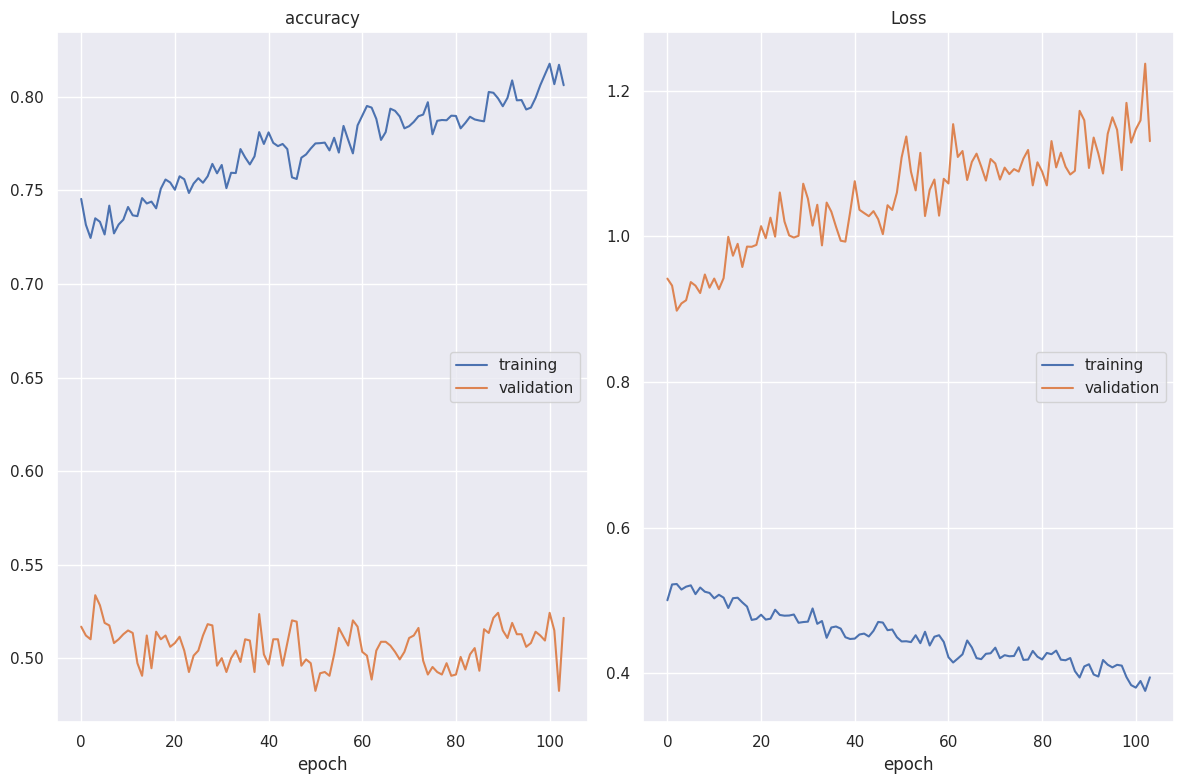

accuracy
	training         	 (min:    0.725, max:    0.818, cur:    0.806)
	validation       	 (min:    0.483, max:    0.534, cur:    0.522)
Loss
	training         	 (min:    0.376, max:    0.523, cur:    0.395)
	validation       	 (min:    0.898, max:    1.237, cur:    1.131)

Epoch 104: val_accuracy did not improve from 0.53365
139/139 [==============================] - 6s 41ms/step - loss: 0.3945 - accuracy: 0.8062 - val_loss: 1.1307 - val_accuracy: 0.5215


In [319]:
model =  train_model(model, 
                      model_name, 
                      train_X=compact_train_tweets_text_data_padded,
                      train_Y=train_users_data_Y,
                      val_X=compact_val_tweets_text_data_padded,
                      val_Y=val_users_data_Y,
                      batch_size=50, 
                      epochs=400,
                      patience=100)

#### Prediction and results

Accuracy: 0.5226027397260274
Precision: [0.52314165 0.52208835]
Recall: 0.5342465753424658
F1 score: 0.528097
ROC AUC: 0.522603


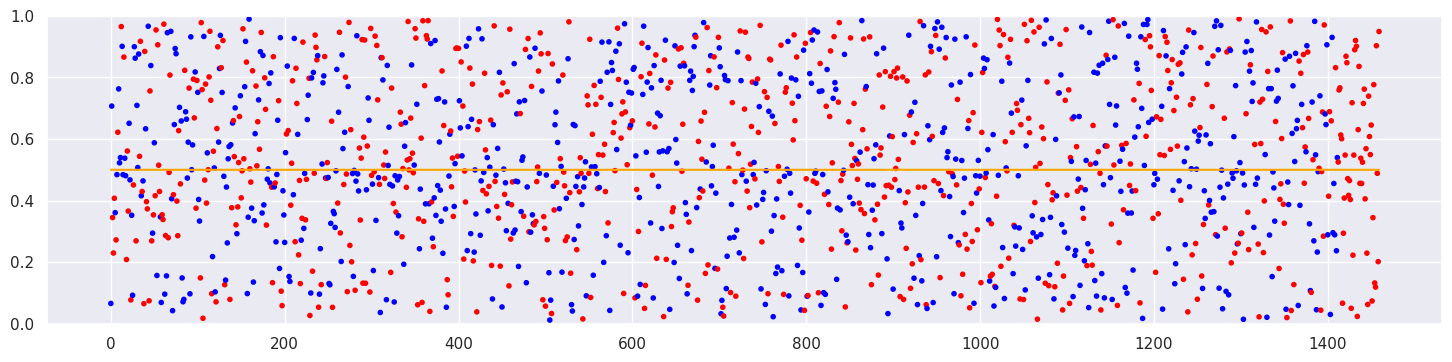

<Figure size 640x480 with 0 Axes>

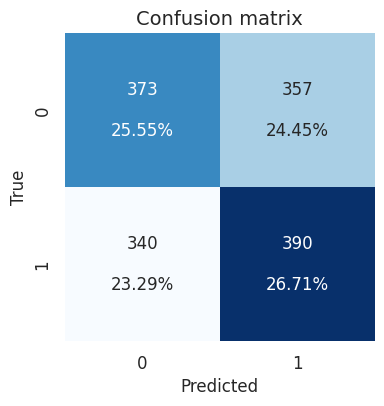

In [320]:
prediction_and_metrics(model, compact_test_tweets_text_data_padded, test_users_data_Y)

### batch_size=100, epochs=300

#### Create and train model

In [321]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_100_20_latest_tweets_of_user_padded_add_feat_only'

model = create_model_1(add_tweets_feat_shape=np.array(compact_train_tweets_text_data_padded[0]).shape,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


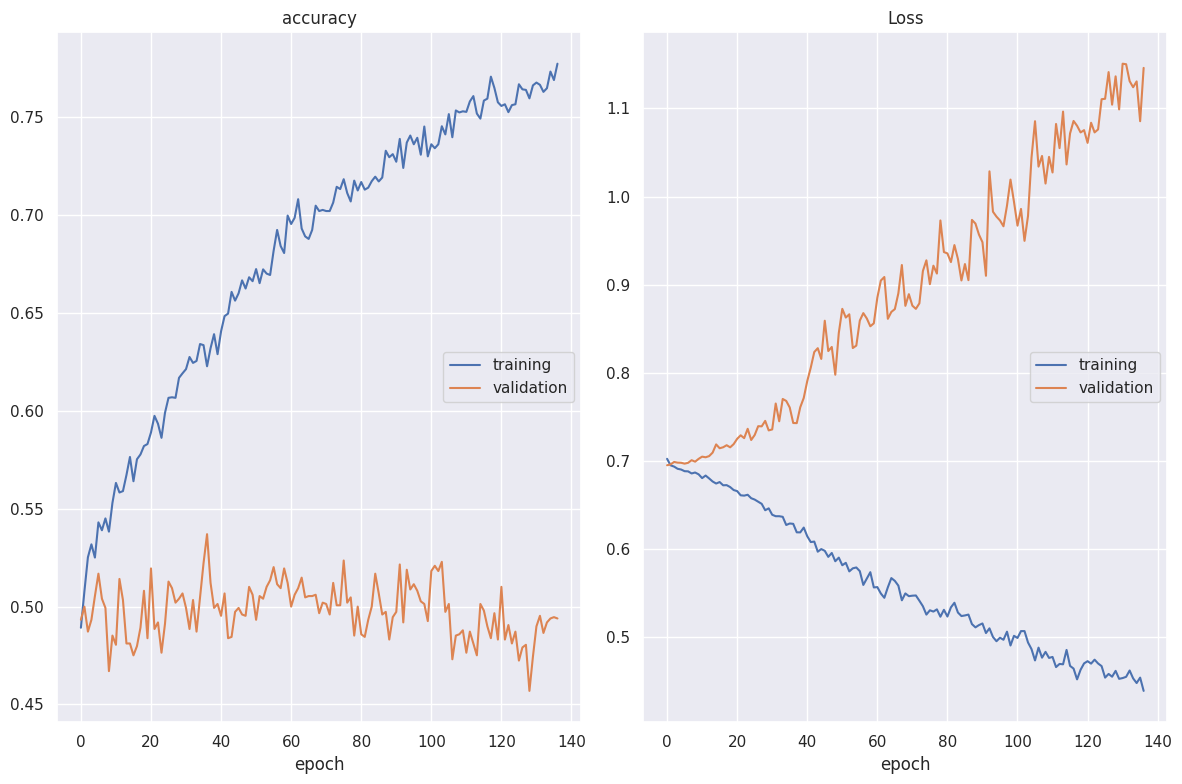

accuracy
	training         	 (min:    0.489, max:    0.777, cur:    0.777)
	validation       	 (min:    0.457, max:    0.537, cur:    0.494)
Loss
	training         	 (min:    0.439, max:    0.702, cur:    0.439)
	validation       	 (min:    0.695, max:    1.151, cur:    1.146)

Epoch 137: val_accuracy did not improve from 0.53701
70/70 [==============================] - 4s 62ms/step - loss: 0.4392 - accuracy: 0.7774 - val_loss: 1.1460 - val_accuracy: 0.4939


In [322]:
model =  train_model(model, 
                      model_name, 
                      train_X=compact_train_tweets_text_data_padded,
                      train_Y=train_users_data_Y,
                      val_X=compact_val_tweets_text_data_padded,
                      val_Y=val_users_data_Y,
                      batch_size=100, 
                      epochs=400,
                      patience=100)

#### Prediction and results

Accuracy: 0.5356164383561643
Precision: [0.53651685 0.53475936]
Recall: 0.547945205479452
F1 score: 0.541272
ROC AUC: 0.535616


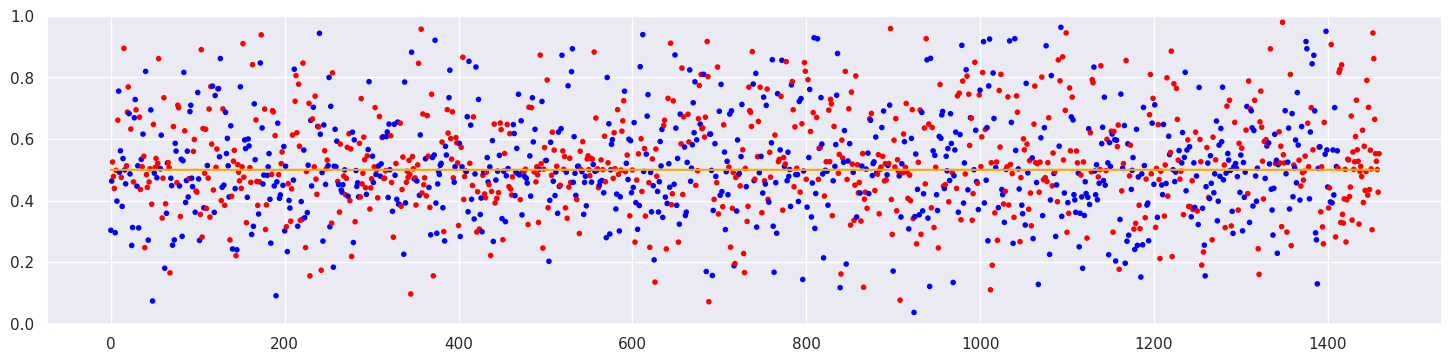

<Figure size 640x480 with 0 Axes>

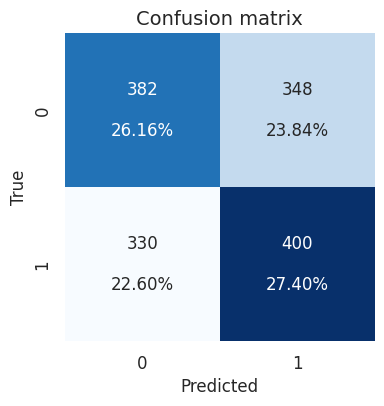

In [323]:
prediction_and_metrics(model, compact_test_tweets_text_data_padded, test_users_data_Y)

### batch_size=250, epochs=300

#### Create and train model

In [324]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_250_20_latest_tweets_of_user_padded_add_feat_only'

model = create_model_1(add_tweets_feat_shape=np.array(compact_train_tweets_text_data_padded[0]).shape,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

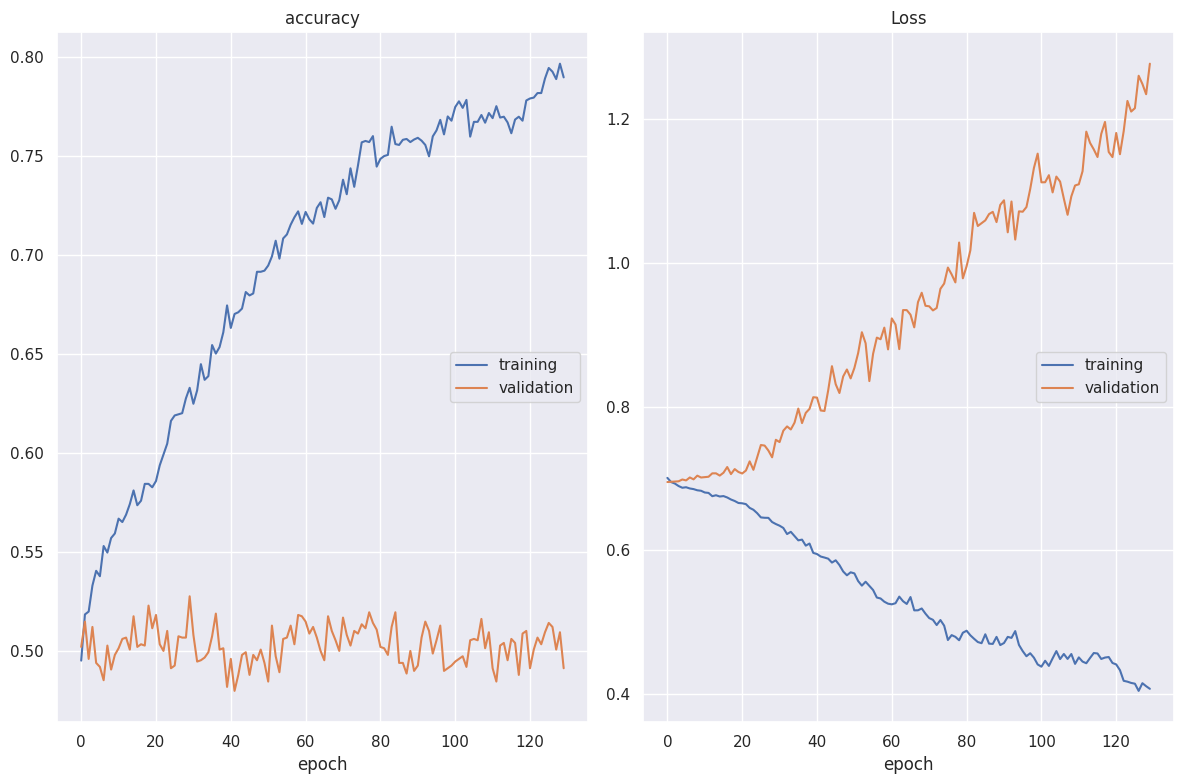

accuracy
	training         	 (min:    0.495, max:    0.797, cur:    0.790)
	validation       	 (min:    0.480, max:    0.528, cur:    0.491)
Loss
	training         	 (min:    0.404, max:    0.701, cur:    0.407)
	validation       	 (min:    0.695, max:    1.277, cur:    1.277)

Epoch 130: val_accuracy did not improve from 0.52759
28/28 [==============================] - 3s 115ms/step - loss: 0.4070 - accuracy: 0.7897 - val_loss: 1.2773 - val_accuracy: 0.4913


In [325]:
model =  train_model(model, 
                      model_name, 
                      train_X=compact_train_tweets_text_data_padded,
                      train_Y=train_users_data_Y,
                      val_X=compact_val_tweets_text_data_padded,
                      val_Y=val_users_data_Y,
                      batch_size=250, 
                      epochs=400,
                      patience=100)

#### Prediction and results

Accuracy: 0.5136986301369864
Precision: [0.515625   0.51219512]
Recall: 0.5753424657534246
F1 score: 0.541935
ROC AUC: 0.513699


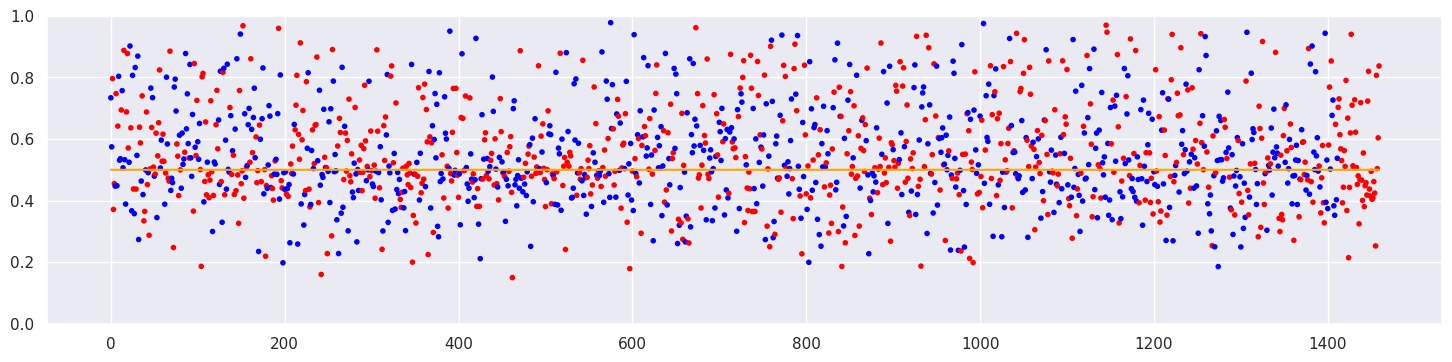

<Figure size 640x480 with 0 Axes>

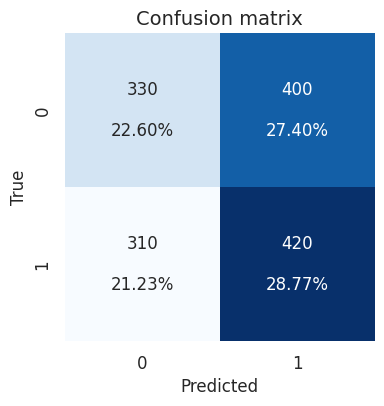

In [326]:
prediction_and_metrics(model, compact_test_tweets_text_data_padded, test_users_data_Y)

#### Prediction on training subset 

Accuracy: 0.6526058162971494
Precision: [0.66708701 0.64043455]
Recall: 0.6959401094154909
F1 score: 0.667035
ROC AUC: 0.652606


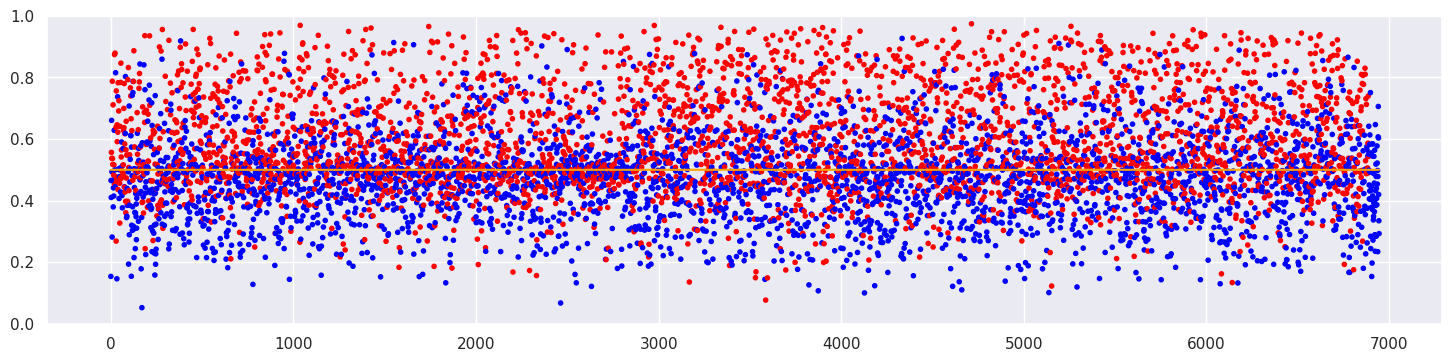

<Figure size 640x480 with 0 Axes>

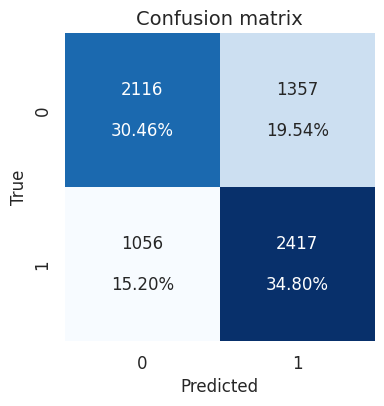

In [327]:
prediction_and_metrics(model, compact_train_tweets_text_data_padded, train_users_data_Y)

### batch_size=500, epochs=300

#### Create and train model

In [328]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_500_20_latest_tweets_of_user_padded_add_feat_only'

model = create_model_1(add_tweets_feat_shape=np.array(compact_train_tweets_text_data_padded[0]).shape,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

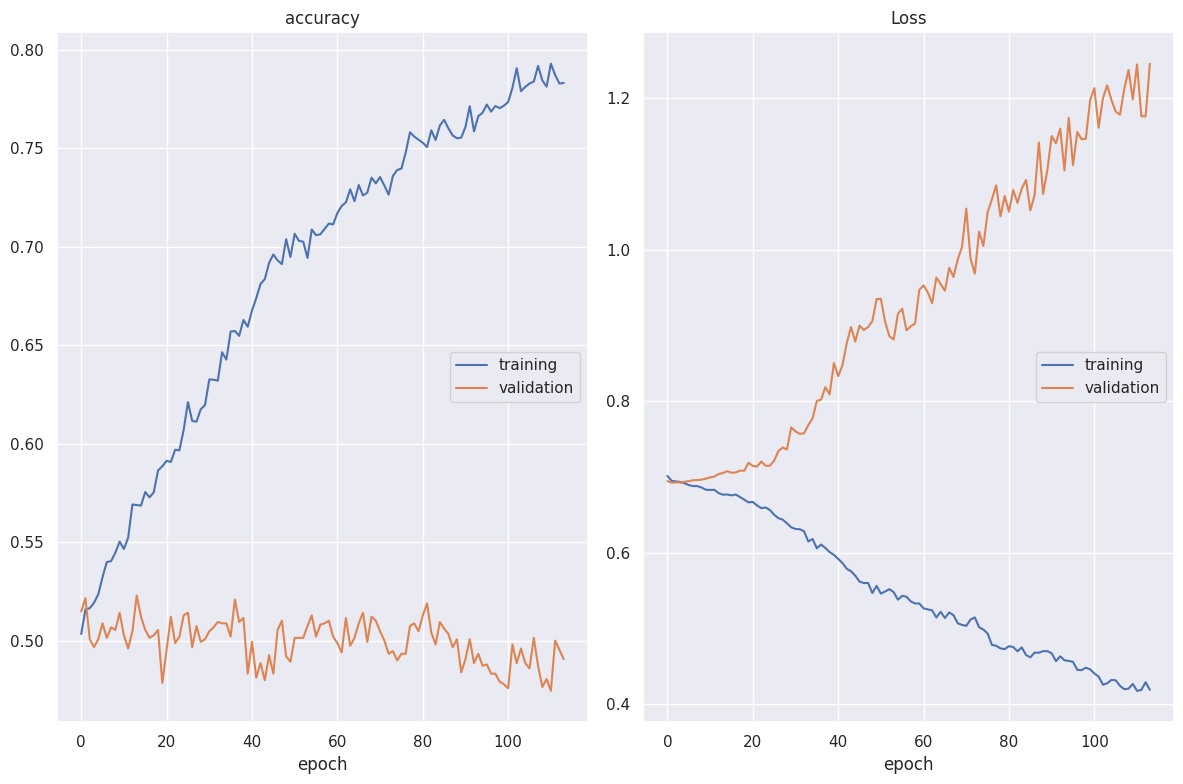

accuracy
	training         	 (min:    0.503, max:    0.793, cur:    0.783)
	validation       	 (min:    0.474, max:    0.523, cur:    0.491)
Loss
	training         	 (min:    0.418, max:    0.702, cur:    0.419)
	validation       	 (min:    0.693, max:    1.246, cur:    1.246)

Epoch 114: val_accuracy did not improve from 0.52288
14/14 [==============================] - 3s 189ms/step - loss: 0.4192 - accuracy: 0.7832 - val_loss: 1.2457 - val_accuracy: 0.4906


In [329]:
model =  train_model(model, 
                      model_name, 
                      train_X=compact_train_tweets_text_data_padded,
                      train_Y=train_users_data_Y,
                      val_X=compact_val_tweets_text_data_padded,
                      val_Y=val_users_data_Y,
                      batch_size=500, 
                      epochs=400,
                      patience=100)

#### Prediction and results

Accuracy: 0.5212328767123288
Precision: [0.52230216 0.52026144]
Recall: 0.5452054794520548
F1 score: 0.532441
ROC AUC: 0.521233


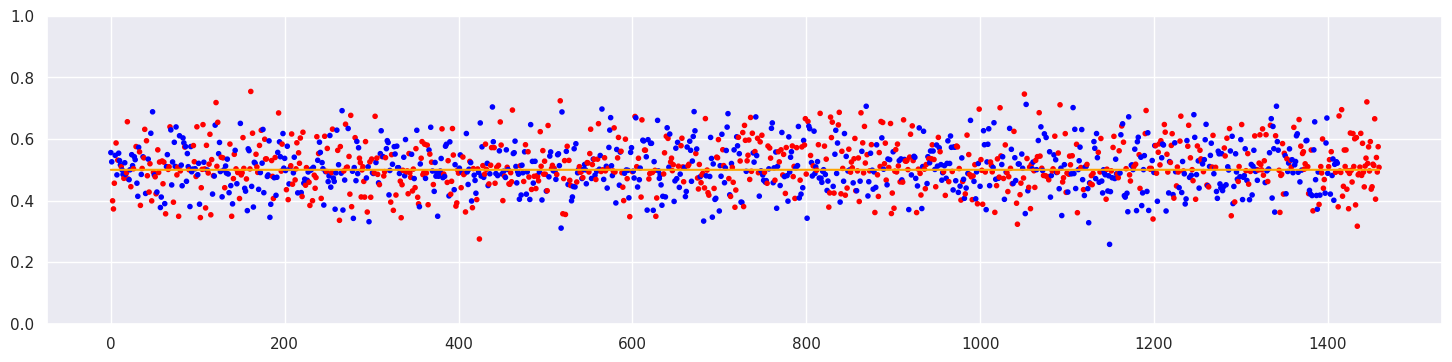

<Figure size 640x480 with 0 Axes>

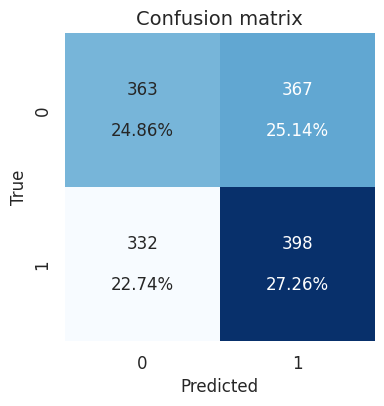

In [330]:
prediction_and_metrics(model, compact_test_tweets_text_data_padded, test_users_data_Y)

## Model 2. 

#### Create model

In [224]:
def create_model_1(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(9,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # Text input
    text_input = Input(shape=(max_sequence_length,))
    # Embedding layer for text
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # LSTM layer
    lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    
    # Concatenate text and additional features
    concatenated = concatenate([lstm_layer, additional_tweet_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    output_layer = Dense(1, activation='sigmoid')(activation_layer1)
    
    model = Model(inputs=[text_input, additional_tweet_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

### batch_size=50, epochs=200

#### Create and train model

In [225]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_50_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


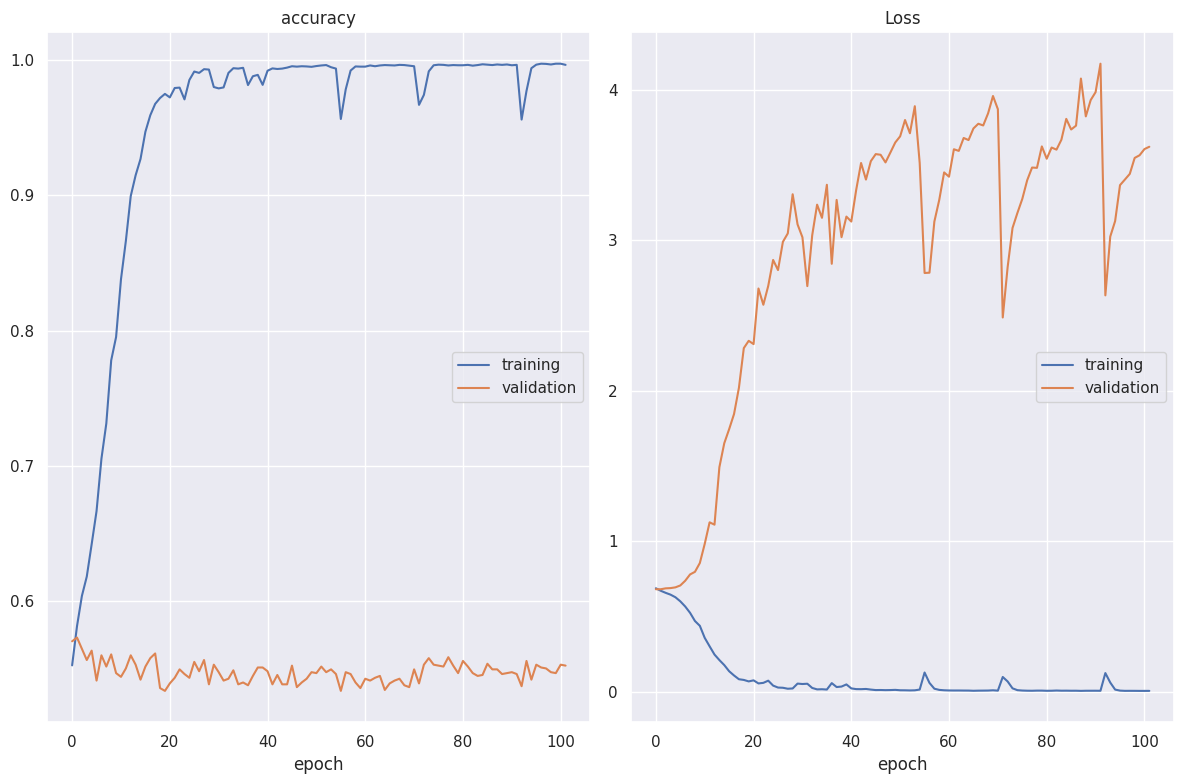

accuracy
	training         	 (min:    0.553, max:    0.997, cur:    0.997)
	validation       	 (min:    0.534, max:    0.573, cur:    0.553)
Loss
	training         	 (min:    0.006, max:    0.688, cur:    0.006)
	validation       	 (min:    0.681, max:    4.173, cur:    3.621)

Epoch 102: val_accuracy did not improve from 0.57331
139/139 [==============================] - 3s 21ms/step - loss: 0.0064 - accuracy: 0.9965 - val_loss: 3.6213 - val_accuracy: 0.5526


In [226]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=50, 
                      epochs=200,
                      patience=100)